# Multiple linear regression model

Applying multiple linear regression to generate a signal for the growth of SPY (the exchange-traded fund tracking S&P 500). Choosing SPY because it's very suitable for trading frequently (cheap prices, low fees, volatility). 

This project will predict data price change of SPY when US market opens in the morning. The difference in timezone causes the Asian market information available for US market at its opening. 

Data from Aord, HSI, Nikkei, CAC40, DAX, S&P500, NASDAQ, DJI to predict the daily price change of SPY. 

In [30]:
import pandas as pd 
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as pdr
%matplotlib inline

In [15]:
start=date(2015,1,1)
end=date(2020,12,31)

## Import all stock market data into DataFrame

In [16]:
aord = pdr.get_data_yahoo('^AORD', start, end, interval='d') # All Ordinary 
nikkei = pdr.get_data_yahoo('^N225', start, end, interval='d') # Nikkei
hsi = pdr.get_data_yahoo('^HSI', start, end, interval='d') #H SI
daxi = pdr.get_data_yahoo('^GDAXI', start, end, interval='d') # Dax Performance Index
cac40 = pdr.get_data_yahoo('^FCHI', start, end, interval='d') # CAC40
sp500 = pdr.get_data_yahoo('^GSPC', start, end, interval='d') # S&P500
dji = pdr.get_data_yahoo('^DJI', start, end, interval='d') # Dow Jones Industrial Average
nasdaq = pdr.get_data_yahoo('^IXIC', start, end, interval='d') # Nasdaq
spy = pdr.get_data_yahoo('SPY', start, end, interval='d') #SPY

In [17]:
spy.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,206.880005,204.179993,206.380005,205.429993,121465900.0,178.278488
2015-01-05,204.369995,201.350006,204.169998,201.720001,169632600.0,175.058868
2015-01-06,202.720001,198.860001,202.089996,199.820007,209151400.0,173.410004
2015-01-07,202.720001,200.880005,201.419998,202.309998,125346700.0,175.570908
2015-01-08,206.160004,203.990005,204.009995,205.899994,147217800.0,178.686401


- All dataset has 6 columns. Open is the price at the beginning. <br>
- High, Low are the highest and lowest prices on that day. <br>
- Adj Close price is the adjusted closing price that has been amended to include any disputions and corporate actions that occured at anytime before the next day's open. <br>
- Volumne is the number of shares traded on that day. <br>
- This project only use open price.  

## Multiple linear regression

$y_i = \beta_0 + \beta_1 * x_i + \beta_2 * x_i\ + \beta_3 * x_i +... $ <br>

Our <b>responses</b> variable is open price of SPY tomorrow minus today's open. With this response, we expect to make a prediction in the morning in US market. Based on those price changes, we decided whether to long or short. 

There are <b>8 predictors</b> divided into 3 groups. <br>
- Group 1: One-day lag variables from US market: Open - Open last day (SPY, SP500, Nasdaq, Dji)
- Group 2: One-day lag variables from European market: Price at noon - Open last day (CAC40, Daxi)
- Group 3: One-day lag variables from Asian market: Close - Open (Aord, HSI, Nikkei)

### Step 1: Data Munging

In [18]:
# First, we generate an empty data frame and let the index be the same as the index of SPY
indicepanel=pd.DataFrame(index=spy.index)

In [19]:
# Add the contents of responses and predictors as defined in the last slide.  

indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']

#Keep a record of open price of SPY
indicepanel['Price']=spy['Open']

In [20]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2015-01-02,-2.210007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.101562,NaN,206.380005
2015-01-05,-2.080002,-2.210007,-4.459961,-59.900391,-1.769531,-72.059570,-133.479492,-83.299805,22.130859,83.031250,204.169998
2015-01-06,-0.669998,-2.080002,-32.289917,-33.489746,-317.121094,-92.100098,-251.400391,-11.700195,-29.720703,-218.390625,202.089996
2015-01-07,2.589996,-0.669998,-16.599976,-40.010254,-129.400391,-18.160156,26.089844,24.899902,284.560547,77.070312,201.419998
2015-01-08,2.389999,2.589996,25.059937,62.700195,217.191406,64.430176,133.429688,80.700195,-84.820312,99.699219,204.009995


In [21]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        16
daxi         33
aord        179
hsi          68
nikkei       94
Price         0
dtype: int64

Missing values (NaN) appear due to 2 reasons: <br>
- When calculating the price change, NaN value is generated in the first row (one day lag) and the last row (one day in the future). <br>
- In different markets, they may have different holidays in which the markets are closed. It can be shown by computing numbers of NaN values in each column. <br>

Fom the data, Australia markets seems to have more holidays in one-year period. <br>

We need to handle NaN values first before viewing the model. 

In [22]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then drop the first row by using dropna
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

# Check if there is any NaN remaining by computing numbers NaN values 
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [23]:
print(indicepanel.shape)

(1510, 11)


In total, we have 1510 days of data, 9 predictors, 1 response and the last column keeps a record of open price of SPY.

### Step 2: Data Spliting

To make sure the model is consistent in future data, current data need to be split into 2 parts: <br>
- One is for building the model
- The other part is for testing the model to see if the model can still make reasonable prediction in this dataset <br>

Stock data is very noisy comparing to other static data like images. We will use the equal size of samples for both train and test. <br>

We assign 500 days at the test data and 500 days before the test at the training data. 

In [28]:
#split the data into (1)train set and (2)test set

Train = indicepanel.iloc[-1000:-500, :]
Test = indicepanel.iloc[-500:, :]
print(Train.shape, Test.shape)

(500, 11) (500, 11)


### Step 3: Explore the train data set

Firstly, we use the scatter matrix to get a pairwise scatterplot.

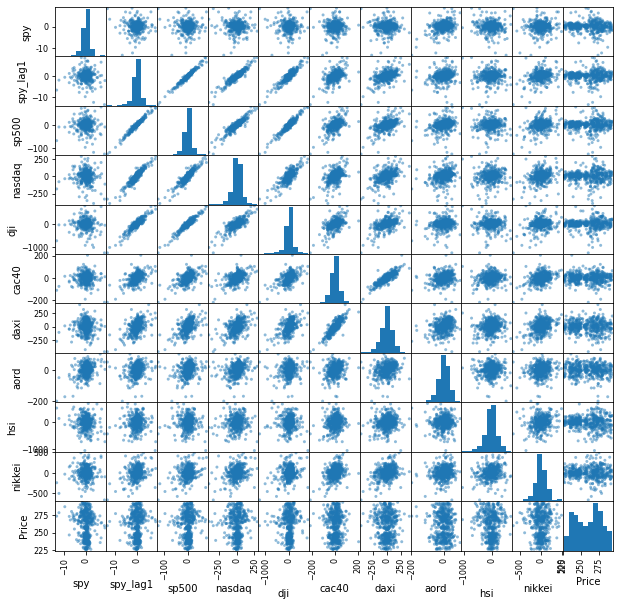

In [32]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association

from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

As you can see in the scatterplots, which will response SPY with other 9 predictors. 

In [35]:
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.033614
sp500      -0.018037
nasdaq     -0.034319
dji        -0.026576
cac40       0.018273
daxi        0.008769
aord        0.352821
hsi        -0.090075
nikkei      0.055477
Name: spy, dtype: float64


From the output, we find that the predictors for Asian and European markets do have association with SPY, which have higher impacts than predictors of U.S. markets. <br>

We need to compute correlation in order to see the association clearly. 

### Step 4: Check the correlation of each index between spy

We can use the OLS method of Stastmodels to build mutiple linear equation.

In [36]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     10.16
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           2.16e-14
Time:                        21:53:48   Log-Likelihood:                -1063.1
No. Observations:                 500   AIC:                             2146.
Df Residuals:                     490   BIC:                             2188.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0594      0.092      0.646      0.519      -0.121       0.240
spy_lag1      -0.2172      0.236     -0.919      0.359      -0.682       0.247
sp500          0.0523      0.032      1.627      0.104      -0.011       0.116
nasdaq        -0.0069      0.004     -1.697      0.090      -0.015       0.001
dji           -0.0018      0.002     -0.966      0.335      -0.005       0.002
cac40          0.0017      0.005      0.372      0.710      -0.007       0.011
aord           0.0231      0.003      8.758      0.000       0.018       0.028
daxi          -0.0018      0.002     -1.000      0.318      -0.005       0.002
nikkei         0.0009      0.001      1.263      0.207      -0.001       0.002
hsi           -0.0009      0.000     -1.988      0.047      -0.002      -1e-05
==============================================================================
Omnibus:                       85.228   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              433.724
Skew:                          -0.626   Prob(JB):                     6.58e-95
Kurtosis:                       7.388   Cond. No.                         603.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- P-value for F-statistics = 2.16e-14 < 0.05, which indicates we rejects H0 and shows that our model includes useful predictors. 
- P-value of Aord = 0 means most of the predictors are not significant, except Aord. Another way to say is all other predictors are useless information of SPY. It may be because of multicollinarity.

In [37]:
# Check the multicollinarity
Train.iloc[:,:-1].corr()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei
spy,1.000000,-0.033614,-0.018037,-0.034319,-0.026576,0.018273,0.008769,0.352821,-0.090075,0.055477
spy_lag1,-0.033614,1.000000,0.980863,0.932790,0.924649,0.530736,0.521366,0.200057,0.029050,0.302716
sp500,-0.018037,0.980863,1.000000,0.920933,0.952637,0.563359,0.553147,0.208900,0.003843,0.295340
nasdaq,-0.034319,0.932790,0.920933,1.000000,0.809816,0.494896,0.496422,0.244396,0.079108,0.280638
dji,-0.026576,0.924649,0.952637,0.809816,1.000000,0.551092,0.541059,0.162162,-0.032998,0.263143
cac40,0.018273,0.530736,0.563359,0.494896,0.551092,1.000000,0.865976,0.235233,0.126759,0.364268
daxi,0.008769,0.521366,0.553147,0.496422,0.541059,0.865976,1.000000,0.259957,0.143870,0.364405
aord,0.352821,0.200057,0.208900,0.244396,0.162162,0.235233,0.259957,1.000000,0.029242,0.161519
hsi,-0.090075,0.029050,0.003843,0.079108,-0.032998,0.126759,0.143870,0.029242,1.000000,0.207754
nikkei,0.055477,0.302716,0.295340,0.280638,0.263143,0.364268,0.364405,0.161519,0.207754,1.000000


Multicollineaity refers to a situation in which 2 or more predictors in the multiple regression model are highly, linearly related. 

### Step 5: Make prediction

<ipython-input-39-dddc07419192>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train['PredictedY'] = lm.predict(Train)
<ipython-input-39-dddc07419192>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['PredictedY'] = lm.predict(Test)


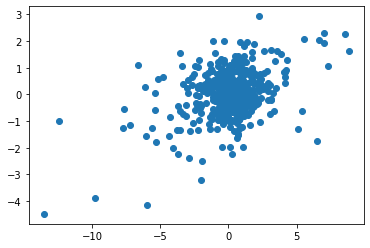

In [39]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

plt.scatter(Train['spy'], Train['PredictedY'])

As the scatter chart shown, it does have positive correlation. 

### Step 6: Model evaluation - Statistical standard

We can evaluate the model by comparing 2 statistics in train and test. <br>
We can measure the performance of our model using some statistical metrics 
- **RMSE**
- **Adjusted $R^2$ **

In [40]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [41]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [42]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'spy')

<ipython-input-40-ed95672825d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['yhat'] = model.predict(data)


,Train,Test
R2,0.141721,0.17854
RMSE,2.049193,4.04738


If RMSE and Adjusted $R^2$ in train is much better in train than in test dataset, the model is overfitting and we cannot implies this model to real market in the future. 

From the output, our model is not overfitted. 

# Evaluating strategy built from Regression model

Build and evaluate the signal based trading strategy

## Profit of Signal-based strategy (Train data)

In [ ]:
# Compute the position of trading. The trading is bosed on the predicted value of a response
Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['spy'] * Train['Order']

#Compute a cumulative profit and sum it in the column of wealth
Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train (500 days): ', Train['Profit'].sum())

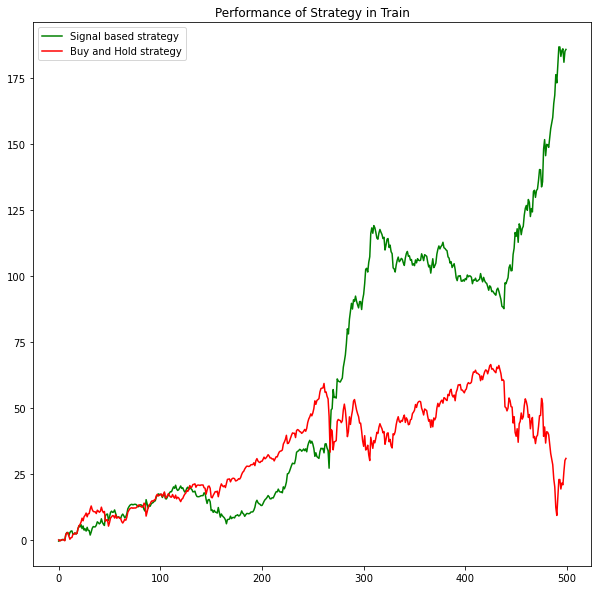

In [48]:
# Compare the performance of Signal-based strategy and passive strategy (By and Hold)
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

As we can see, Signal-based strategy outperforms Buy-and-hold strategy. 

## Profit of Signal-based strategy (Test data)

In [52]:
# Compute the position of trading. The trading is bosed on the predicted value of a response
Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']

#Compute a cumulative profit and sum it in the column of wealth
Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test (500 days): ', Test['Profit'].sum())

Total profit made in Test (500 days):  309.29949951171875


<ipython-input-52-482c937446e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
<ipython-input-52-482c937446e4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Profit'] = Test['spy'] * Test['Order']
<ipython-input-52-482c937446e4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

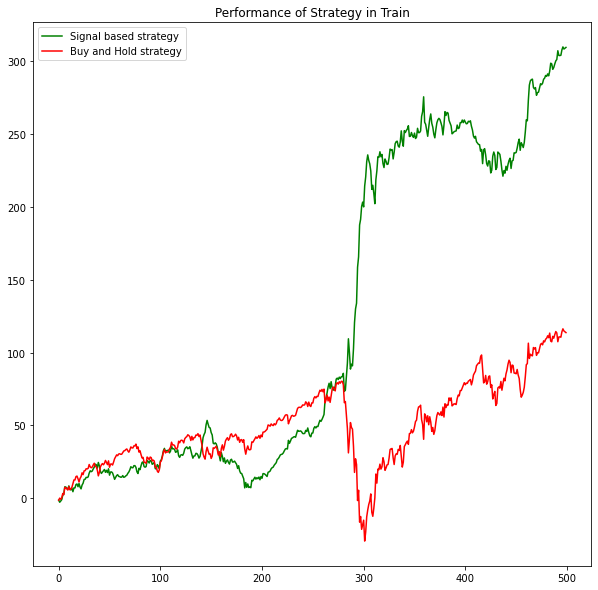

In [53]:
# Compare the performance of Signal-based strategy and passive strategy (By and Hold)
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

The consistency of performance is very important. Otherwise, it is too risky to apply it in the future. 

## Evaluation of model practical standard

We introduce two common practical standards to evaluate our model performance <br>
- **Sharpe Ratio**: Measures the excess return (or risk premium) per unit of deviation in an investment asset or a trading strategy, typically regerred to as risk. <br>
- **Maximum Drawdown** <br>

In [54]:
Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

<ipython-input-54-5bea9024a0ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
<ipython-input-54-5bea9024a0ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']


In [55]:
# Sharpe Ratio on Train data
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.17135184521883115
Yearly Sharpe Ratio is  2.7201262148463563


<ipython-input-55-516249e86291>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))


In [56]:
# Sharpe Ratio in Test data
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.15719613063357335
Yearly Sharpe Ratio is  2.495411212308344


<ipython-input-56-40d44981b4b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))


In [57]:
# Maximum Drawdown in Train data
Train['Peak'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

Maximum Drawdown in Train is  0.09095422077712831


<ipython-input-57-8c57b9fc757a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train['Peak'] = Train['Wealth'].cummax()
<ipython-input-57-8c57b9fc757a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']


In [58]:
# Maximum Drawdown in Test data
Test['Peak'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Maximum Drawdown in Test is  0.14882022213344395


<ipython-input-58-a6c2d38482df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Peak'] = Test['Wealth'].cummax()
<ipython-input-58-a6c2d38482df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
